### Indian Institute of Information Technology Raichur

**Name:** K. V. Jaya Harsha  
**Roll No:** CS23B1034  
**Course:** Deep Learning for Medical Imaging  

---

#### Project 1: Brain MRI Tumor Segmentation  
##### A Comparative Study of Otsu and Sauvola Thresholding

**Dataset:** Kaggle Brain MRI Tumor Dataset  
**Objective:** Tumor region segmentation from MRI slices  
**Evaluation Metrics:** Dice Score, Jaccard Index  


In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu, threshold_sauvola
from sklearn.metrics import jaccard_score
import kagglehub


In [2]:
path = kagglehub.dataset_download("bilalakgz/brain-tumor-mri-dataset")
print("Dataset path:", path)

100%|██████████| 92.1M/92.1M [00:00<00:00, 173MB/s] 

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/bilalakgz/brain-tumor-mri-dataset/versions/1


In [3]:
SEG_PATH = os.path.join(path, "brain_tumor_dataset", "brain_tumor_segmentation")

print("Segmentation folder:", SEG_PATH)
print("Contents:", os.listdir(SEG_PATH))


Segmentation folder: /root/.cache/kagglehub/datasets/bilalakgz/brain-tumor-mri-dataset/versions/1/brain_tumor_dataset/brain_tumor_segmentation
Contents: ['data.yaml', 'README.roboflow.txt', 'README.dataset.txt', 'valid', 'test', 'train']


In [4]:
for root, dirs, files in os.walk(SEG_PATH):
    print("Folder:", root)
    print("Subfolders:", dirs)
    print("Files:", files[:5])
    print("-"*40)


Folder: /root/.cache/kagglehub/datasets/bilalakgz/brain-tumor-mri-dataset/versions/1/brain_tumor_dataset/brain_tumor_segmentation
Subfolders: ['valid', 'test', 'train']
Files: ['data.yaml', 'README.roboflow.txt', 'README.dataset.txt']
----------------------------------------
Folder: /root/.cache/kagglehub/datasets/bilalakgz/brain-tumor-mri-dataset/versions/1/brain_tumor_dataset/brain_tumor_segmentation/valid
Subfolders: ['images', 'labels']
Files: []
----------------------------------------
Folder: /root/.cache/kagglehub/datasets/bilalakgz/brain-tumor-mri-dataset/versions/1/brain_tumor_dataset/brain_tumor_segmentation/valid/images
Subfolders: []
Files: ['glioma12_jpg.rf.7a7fa1ffad85402faebfb41c8a72ecc4.jpg', 'meningioma32_jpg.rf.c3ed8995070fa81464c73c14dd78f2f7.jpg', 'glioma47_jpg.rf.1eb0ab4b637180ad0dc03018ba3db6bc.jpg', 'glioma24_jpg.rf.0e5a2fb3effba56e6acb73c28ad0702f.jpg', 'glioma15_jpg.rf.a1b8fdac1bc80696c841a8d897bcb8ed.jpg']
----------------------------------------
Folder: /root

In [5]:
TRAIN_IMAGES = os.path.join(SEG_PATH, "train", "images")
TRAIN_LABELS = os.path.join(SEG_PATH, "train", "labels")

print("Train Images:", len(os.listdir(TRAIN_IMAGES)))
print("Train Labels:", len(os.listdir(TRAIN_LABELS)))


Train Images: 102
Train Labels: 102


In [6]:
def yolo_to_mask(label_path, image_shape):
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    
    with open(label_path, 'r') as f:
        lines = f.readlines()
        
    for line in lines:
        parts = list(map(float, line.strip().split()))
        coords = parts[1:]  # skip class id
        
        polygon = []
        for i in range(0, len(coords), 2):
            x = int(coords[i] * image_shape[1])
            y = int(coords[i+1] * image_shape[0])
            polygon.append([x, y])
        
        polygon = np.array([polygon], dtype=np.int32)
        cv2.fillPoly(mask, polygon, 1)
    
    return mask


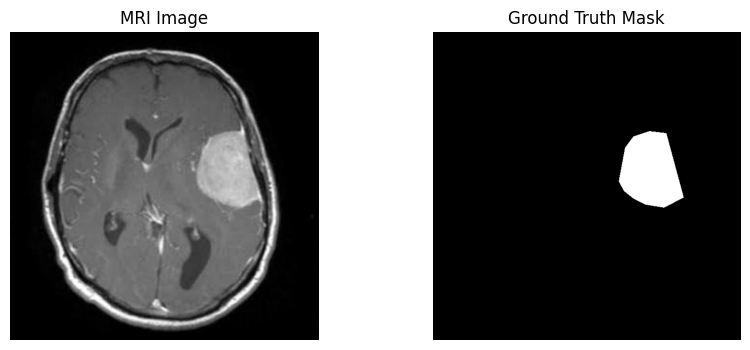

In [7]:
img_name = os.listdir(TRAIN_IMAGES)[0]

image_path = os.path.join(TRAIN_IMAGES, img_name)
label_name = img_name.replace(".jpg", ".txt")
label_path = os.path.join(TRAIN_LABELS, label_name)

image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
gt_mask = yolo_to_mask(label_path, image.shape)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(image, cmap='gray')
plt.title("MRI Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(gt_mask, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis("off")

plt.show()


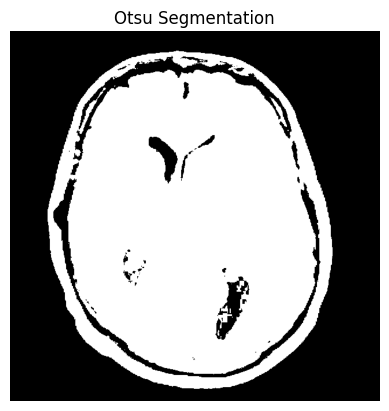

In [8]:
def apply_otsu(image):
    thresh = threshold_otsu(image)
    return (image > thresh).astype(np.uint8)

otsu_pred = apply_otsu(image)

plt.imshow(otsu_pred, cmap='gray')
plt.title("Otsu Segmentation")
plt.axis("off")
plt.show()


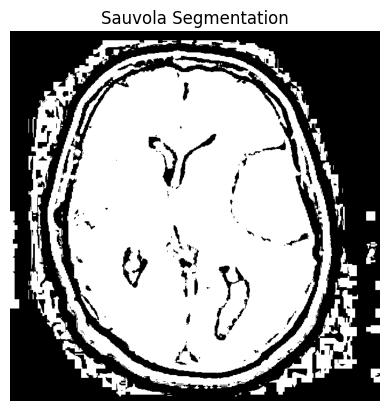

In [9]:
def apply_sauvola(image):
    window_size = 25
    thresh = threshold_sauvola(image, window_size=window_size)
    return (image > thresh).astype(np.uint8)

sauvola_pred = apply_sauvola(image)

plt.imshow(sauvola_pred, cmap='gray')
plt.title("Sauvola Segmentation")
plt.axis("off")
plt.show()


In [10]:
def dice_score(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-6)

def jaccard(y_true, y_pred):
    return jaccard_score(y_true.flatten(), y_pred.flatten())

print("Otsu Dice:", dice_score(gt_mask, otsu_pred))
print("Sauvola Dice:", dice_score(gt_mask, sauvola_pred))

print("Otsu Jaccard:", jaccard(gt_mask, otsu_pred))
print("Sauvola Jaccard:", jaccard(gt_mask, sauvola_pred))


Otsu Dice: 0.13907445536302013
Sauvola Dice: 0.12429575043731503
Otsu Jaccard: 0.07473402456347174
Sauvola Jaccard: 0.06626617733943412


In [11]:
dice_otsu_all = []
dice_sauvola_all = []

for img_name in os.listdir(TRAIN_IMAGES):
    
    image_path = os.path.join(TRAIN_IMAGES, img_name)
    label_name = img_name.replace(".jpg", ".txt")
    label_path = os.path.join(TRAIN_LABELS, label_name)
    
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    gt_mask = yolo_to_mask(label_path, image.shape)
    
    otsu = apply_otsu(image)
    sauvola = apply_sauvola(image)
    
    dice_otsu_all.append(dice_score(gt_mask, otsu))
    dice_sauvola_all.append(dice_score(gt_mask, sauvola))

print("Average Dice Otsu:", np.mean(dice_otsu_all))
print("Average Dice Sauvola:", np.mean(dice_sauvola_all))


Average Dice Otsu: 0.10161783554360669
Average Dice Sauvola: 0.0600104365790134


/tmp/ipython-input-3040328225.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([dice_otsu_all, dice_sauvola_all], labels=["Otsu", "Sauvola"])


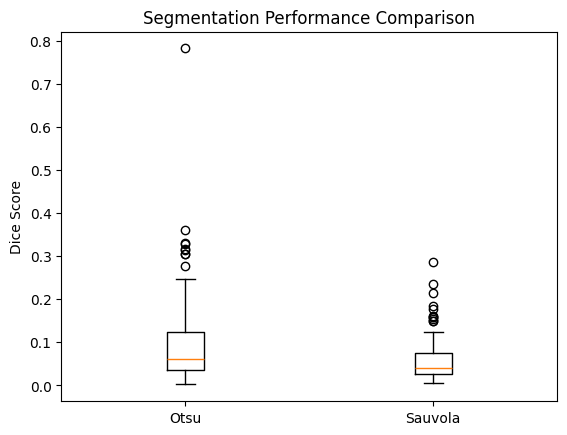

In [12]:
plt.boxplot([dice_otsu_all, dice_sauvola_all], labels=["Otsu", "Sauvola"])
plt.ylabel("Dice Score")
plt.title("Segmentation Performance Comparison")
plt.show()
